In [1]:
import torch
import torchvision
from torch import nn, optim
from tqdm.notebook import tqdm

In [10]:
tr = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

cifar10_data = torchvision.datasets.CIFAR10("cifar10_train_data", download=True, transform=tr)
test_data = torchvision.datasets.CIFAR10("cifar10_test_data", download=True, train=False, transform=tr)

dataloader = torch.utils.data.DataLoader(cifar10_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Files already downloaded and verified


100.0%

Extracting cifar10_test_data/cifar-10-python.tar.gz to cifar10_test_data


In [5]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv11 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv12 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv21 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        
        self.linear1 = nn.Linear(4096, 256)
        self.linear2 = nn.Linear(256, 10)
        
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,X):
        n = X.size(0)
        
        X = self.relu(self.conv11(X))
        X = self.relu(self.conv12(X))
        X = self.pool(X)
        
        X = self.relu(self.conv21(X))
        X = self.relu(self.conv22(X))
        X = self.pool(X)
        
        X = X.view(n,-1)
        
        X = self.relu(self.linear1(X))
        X = self.softmax(self.linear2(X))
        return X
        

In [6]:
model = CNN1()
device=torch.device("cuda:0")
model.cuda()

loss_fn = nn.CrossEntropyLoss()
params = model.parameters()
optimizer = optim.SGD(params = params,lr=.01, momentum=0.9)

n_epochs = 15

for e in tqdm(range(n_epochs)):
    running_loss = 0
    for i,(images,labels) in tqdm(enumerate(dataloader)):
        #forward pass
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        
        #backward pass
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(dataloader)))

Epoch 1 - Training loss: 1.9018806726731303
Epoch 2 - Training loss: 1.3884457120352693
Epoch 3 - Training loss: 1.1404465804319552
Epoch 4 - Training loss: 0.9417945816160163
Epoch 5 - Training loss: 0.7740221536144272
Epoch 6 - Training loss: 0.6196006882526076
Epoch 7 - Training loss: 0.46443821232565835
Epoch 8 - Training loss: 0.34503857944818106
Epoch 9 - Training loss: 0.24994505120588995
Epoch 10 - Training loss: 0.18782695459054255
Epoch 11 - Training loss: 0.15193000015304864
Epoch 12 - Training loss: 0.12834104848430133
Epoch 13 - Training loss: 0.11270952978304795
Epoch 14 - Training loss: 0.09760398511796275
Epoch 15 - Training loss: 0.09540533868606677


In [13]:
correct_count, all_count = 0, 0

incorrect = [[]]

for images,labels in testloader:
    images, labels = images.to(device), labels.to(device)
    for i in range(len(labels)):
        img = images[i].view(1, 3, 32, 32)
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu().numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        else:
            incorrect.append([images[i],pred_label,true_label])
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.6897


In [14]:
torch.save(model.state_dict(), "cifarmodel.pt")

In [15]:
len(incorrect)

3104

[1, 4]
[0, 2]
[3, 5]
[5, 4]
[4, 3]


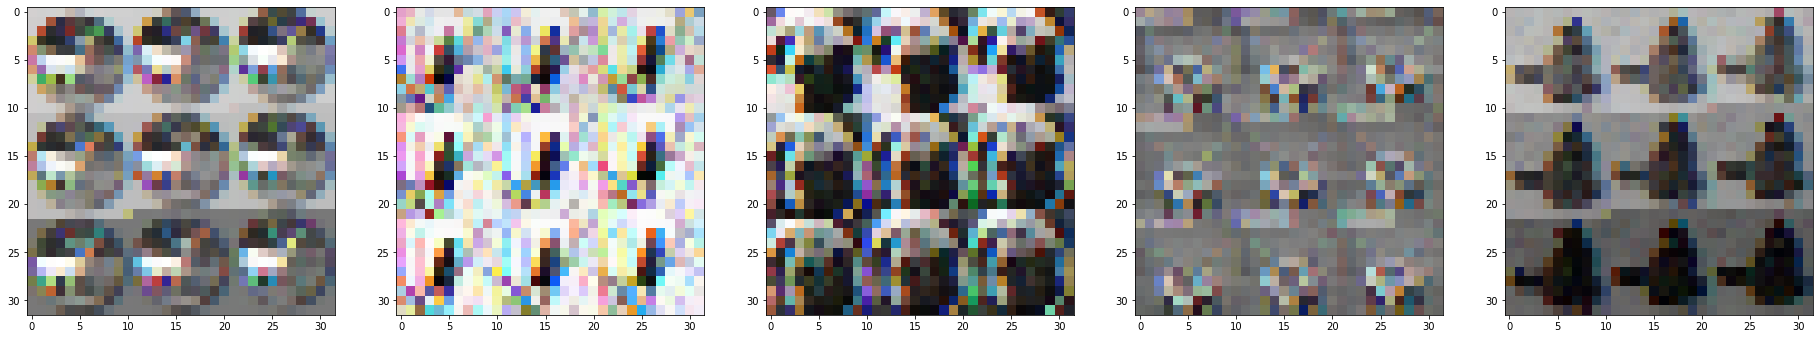

In [18]:
incorrect = [x for x in incorrect if x != []]

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(32,32))

for i,im in enumerate(axes.flat):
    im.imshow(incorrect[i][0].permute(1,2,0))
    
for k in range(5):
    print(incorrect[k][1:])

In [4]:
model = CNN1()
model.load_state_dict(torch.load("mymodel.pt"))
model.eval()

CNN1(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax()
)

19
[4, 6]


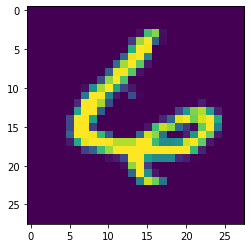

In [53]:
import random
index = random.randrange(0,len(incorrect))
print(index)
plt.imshow(incorrect[index][0].permute(1,2,0))
print(incorrect[index][1:])